# without CPU speeding up

In [14]:
import logging
from SALib.sample import saltelli
from SALib.analyze import sobol
import pandas as pd
import numpy as np
from tqdm import tqdm
from src.SugarScape import SugarScape
from src.Agents.Cell import Cell
from src.Agents.Trader import Trader

def setup_logger():
    """Set up the logger for the simulation."""
    logger = logging.getLogger("simulation")
    handler = logging.FileHandler("simulation.log")
    formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
    handler.setFormatter(formatter)
    logger.addHandler(handler)
    logger.setLevel(logging.INFO)
    return logger

def run_model(variable_parameters):
    """Run the SugarScape model with the given parameters and log the process."""
    logger = setup_logger()
    model = SugarScape(metabolism_mean=variable_parameters['metabolism_mean'], 
                       vision_mean=variable_parameters['vision'])
    for step in range(max_steps):
        model.step()
        if step % 10 == 0:  # Output every 10 steps
            logger.info(f"Model step {step}: metabolism_mean={variable_parameters['metabolism_mean']}, vision={variable_parameters['vision']}")
    total_population = model.schedule.get_agent_count()
    gini_coefficient = model.datacollector.get_model_vars_dataframe()['Gini'].values[-1]
    logger.info(f"Finished: metabolism_mean={variable_parameters['metabolism_mean']}, vision={variable_parameters['vision']}, total_population={total_population}, gini_coefficient={gini_coefficient}")
    return variable_parameters['metabolism_mean'], variable_parameters['vision'], total_population, gini_coefficient

# Define the variables and their ranges
problem = {
    'num_vars': 2,
    'names': ['metabolism_mean', 'vision'],
    'bounds': [[1, 10], [2, 12]]
}

# Set the experiment parameters
replicates = 2  # Simplified for debugging
max_steps = 20  # Increased number of steps
distinct_samples = 2  # Set as 2^n

# Generate parameter samples
param_values = saltelli.sample(problem, distinct_samples)
total_runs = replicates * len(param_values)
print('total_runs:', total_runs)

# Create a list of parameter sets
param_list = []
for i in range(replicates):
    for vals in param_values:
        # Convert the parameter sample values to integers
        variable_parameters = {name: int(val) for name, val in zip(problem['names'], vals)}
        param_list.append(variable_parameters)
print('param_list:', param_list)

# Initialize data storage
data = pd.DataFrame(index=range(total_runs), 
                    columns=['metabolism_mean', 'vision', 'Total Population', 'Gini Coefficient'])

# Run the model sequentially
if __name__ == "__main__":
    results = []
    for params in tqdm(param_list):
        results.append(run_model(params))

    # Store the results
    for count, result in enumerate(results):
        data.iloc[count, :] = result

    print("All experiments done!")

    # Save results to a CSV file
    data.to_csv('simulation_results.csv', index=False)



<ipython-input-14-a72fc5e66564>:46: DeprecationWarning: `salib.sample.saltelli` will be removed in SALib 1.5. Please use `salib.sample.sobol`
  param_values = saltelli.sample(problem, distinct_samples)
  0%|          | 0/24 [00:00<?, ?it/s]

total_runs: 24
param_list: [{'metabolism_mean': 1, 'vision': 6}, {'metabolism_mean': 5, 'vision': 6}, {'metabolism_mean': 1, 'vision': 8}, {'metabolism_mean': 1, 'vision': 8}, {'metabolism_mean': 5, 'vision': 6}, {'metabolism_mean': 5, 'vision': 8}, {'metabolism_mean': 6, 'vision': 11}, {'metabolism_mean': 9, 'vision': 11}, {'metabolism_mean': 6, 'vision': 3}, {'metabolism_mean': 6, 'vision': 3}, {'metabolism_mean': 9, 'vision': 11}, {'metabolism_mean': 9, 'vision': 3}, {'metabolism_mean': 1, 'vision': 6}, {'metabolism_mean': 5, 'vision': 6}, {'metabolism_mean': 1, 'vision': 8}, {'metabolism_mean': 1, 'vision': 8}, {'metabolism_mean': 5, 'vision': 6}, {'metabolism_mean': 5, 'vision': 8}, {'metabolism_mean': 6, 'vision': 11}, {'metabolism_mean': 9, 'vision': 11}, {'metabolism_mean': 6, 'vision': 3}, {'metabolism_mean': 6, 'vision': 3}, {'metabolism_mean': 9, 'vision': 11}, {'metabolism_mean': 9, 'vision': 3}]


2024-06-22 15:44:27,854 - INFO - Model step 0: metabolism_mean=1, vision=6
2024-06-22 15:44:33,099 - INFO - Model step 10: metabolism_mean=1, vision=6
2024-06-22 15:44:38,008 - INFO - Finished: metabolism_mean=1, vision=6, total_population=4338, gini_coefficient=0.23580780899443976
  4%|▍         | 1/24 [00:11<04:15, 11.11s/it]2024-06-22 15:44:38,244 - INFO - Model step 0: metabolism_mean=5, vision=6
2024-06-22 15:44:39,819 - INFO - Model step 10: metabolism_mean=5, vision=6
2024-06-22 15:44:40,907 - INFO - Finished: metabolism_mean=5, vision=6, total_population=2723, gini_coefficient=0.3624365214429375
  8%|▊         | 2/24 [00:14<02:18,  6.28s/it]2024-06-22 15:44:41,292 - INFO - Model step 0: metabolism_mean=1, vision=8
2024-06-22 15:44:48,640 - INFO - Model step 10: metabolism_mean=1, vision=8
2024-06-22 15:44:55,756 - INFO - Finished: metabolism_mean=1, vision=8, total_population=4436, gini_coefficient=0.22059159941979645
 12%|█▎        | 3/24 [00:28<03:34, 10.19s/it]2024-06-22 15:

All experiments done!


# with CPU speeding up
but not functioning well i think cuz the printing is stuck
i dont know why its stuck

In [ ]:
import logging
from SALib.sample import saltelli
from SALib.analyze import sobol
import pandas as pd
import numpy as np
from tqdm import tqdm
from src.SugarScape import SugarScape
from src.Agents.Cell import Cell
from src.Agents.Trader import Trader
from multiprocessing import Pool, cpu_count
import os

def setup_logger():
    """Set up a logger for each worker process."""
    logger = logging.getLogger(f"worker_{os.getpid()}")
    handler = logging.FileHandler(f"worker_{os.getpid()}.log")
    formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
    handler.setFormatter(formatter)
    logger.addHandler(handler)
    logger.setLevel(logging.INFO)
    return logger

def run_model(variable_parameters):
    """Run the SugarScape model with given parameters and log the process."""
    logger = setup_logger()
    model = SugarScape(metabolism_mean=variable_parameters['metabolism_mean'], 
                       vision_mean=variable_parameters['vision'])
    for step in range(max_steps):
        model.step()
        if step % 10 == 0:  # Log every 10 steps
            logger.info(f"Model step {step}: metabolism_mean={variable_parameters['metabolism_mean']}, vision={variable_parameters['vision']}")
    total_population = model.schedule.get_agent_count()
    gini_coefficient = model.datacollector.get_model_vars_dataframe()['Gini'].values[-1]
    logger.info(f"Finished: metabolism_mean={variable_parameters['metabolism_mean']}, vision={variable_parameters['vision']}, total_population={total_population}, gini_coefficient={gini_coefficient}")
    return variable_parameters['metabolism_mean'], variable_parameters['vision'], total_population, gini_coefficient

# Define the problem and its variable ranges
problem = {
    'num_vars': 2,
    'names': ['metabolism_mean', 'vision'],
    'bounds': [[1, 10], [2, 12]]
}

# Set experiment parameters
replicates = 2  # Number of replicates for each parameter set
max_steps = 20  # Number of steps in the model
distinct_samples = 2  # Number of distinct samples, set as a power of 2

# Generate parameter samples
param_values = saltelli.sample(problem, distinct_samples)
total_runs = replicates * len(param_values)
print('total_runs:', total_runs)

# Create a list of parameter sets
param_list = []
for i in range(replicates):
    for vals in param_values:
        # Convert parameter sample values to integers
        variable_parameters = {name: int(val) for name, val in zip(problem['names'], vals)}
        param_list.append(variable_parameters)
print('param_list:', param_list)

# Initialize data storage
data = pd.DataFrame(index=range(total_runs), 
                    columns=['metabolism_mean', 'vision', 'Total Population', 'Gini Coefficient'])

# Run the model in parallel
if __name__ == "__main__":
    with Pool(cpu_count()) as pool:
        results = list(tqdm(pool.imap(run_model, param_list), total=total_runs))

    # Store the results
    for count, result in enumerate(results):
        data.iloc[count, :] = result

    print("All experiments done!")

    # Save results to a CSV file
    data.to_csv('simulation_results.csv', index=False)


# Plotting

                       ST   ST_conf
metabolism_mean  1.228635  0.636026
vision           0.006019  0.234034
                       S1   S1_conf
metabolism_mean  0.518833  4.866178
vision           0.025026  2.951519
                                 S2   S2_conf
(metabolism_mean, vision)  1.497835  8.155634
                       ST   ST_conf
metabolism_mean  2.188020  1.497316
vision           0.206222  0.690893
                       S1   S1_conf
metabolism_mean  0.957911  0.504092
vision          -0.113240  0.293428
                                 S2   S2_conf
(metabolism_mean, vision)  1.922481  1.559674


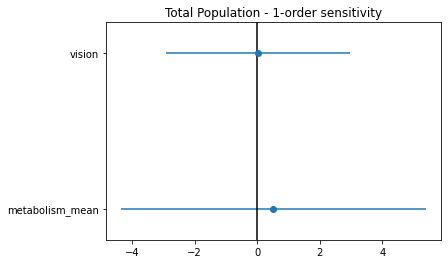

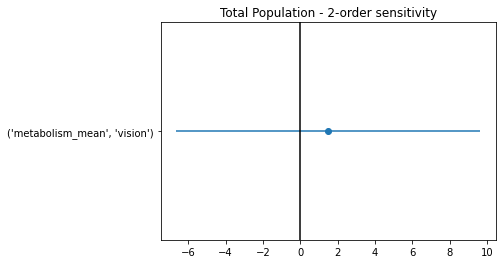

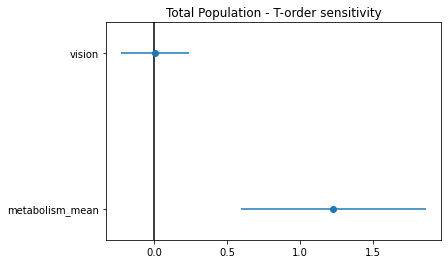

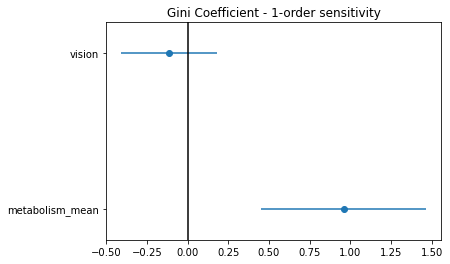

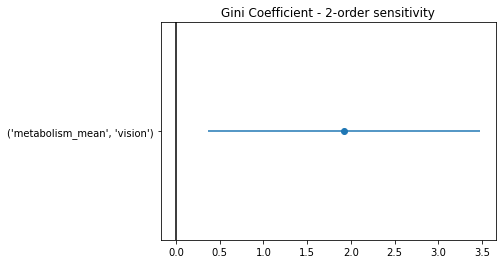

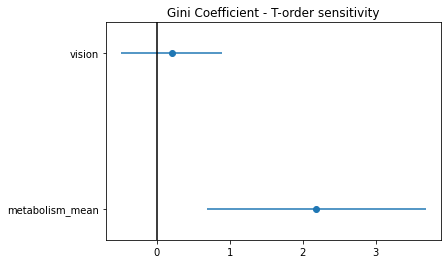

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
from SALib.analyze import sobol
from itertools import combinations
import numpy as np

# Read experiment results
data = pd.read_csv('simulation_results.csv')

# Define variables and their ranges
problem = {
    'num_vars': 2,
    'names': ['metabolism_mean', 'vision'],
    'bounds': [[1, 10], [2, 12]]
}

# Perform Sobol sensitivity analysis
Si_population = sobol.analyze(problem, data['Total Population'].values, print_to_console=True)
Si_gini = sobol.analyze(problem, data['Gini Coefficient'].values, print_to_console=True)

# Visualization function for sensitivity indices
def plot_index(s, params, i, title=''):
    if i == '2':
        p = len(params)
        params = list(combinations(params, 2))
        indices = s['S' + i].reshape((p ** 2))
        # Filter indices to exclude NaN values
        indices = indices[~np.isnan(indices)]
        errors = s['S' + i + '_conf'].reshape((p ** 2))
        # Filter errors to exclude NaN values
        errors = errors[~np.isnan(errors)]
    else:
        indices = s['S' + i]
        errors = s['S' + i + '_conf']
        plt.figure()

    l = len(indices)
    plt.title(title)
    plt.ylim([-0.2, len(indices) - 1 + 0.2])
    plt.yticks(range(l), params)
    plt.errorbar(indices, range(l), xerr=errors, linestyle='None', marker='o')
    plt.axvline(0, c='k')

# Plot sensitivity indices
for Si, output_name in [(Si_population, "Total Population"), (Si_gini, "Gini Coefficient")]:
    for i in ['1', '2', 'T']:
        plot_index(Si, problem['names'], i, f'{output_name} - {i}-order sensitivity')
        plt.show()

